In [1]:
import sqlite3
import numpy as np
import pandas as pd
from astropy.io import fits
import seaborn as sns
from tqdm import tqdm
import lightkurve as lk
import matplotlib.pyplot as plt
sns.set_palette('colorblind')
sns.set_context('poster')
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

Bin into hours, take RMS of that

Dataval, noise model, mikkel wrote it

In [2]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

In [3]:
from bottleneck import nanmedian, nanmean, allnan
from scipy.stats import binned_statistic

mad_to_sigma = 1.482602218505602 #: Conversion constant from MAD to Sigma. Constant is 1/norm.ppf(3/4)

def rms_timescale(time, flux, timescale=3600/86400):
    """
    Compute robust RMS on specified timescale. Using MAD scaled to RMS.
    """
    
    lc = lk.LightCurve(time=time, flux=flux)
    if len(lc.flux) == 0 or allnan(lc.flux):
        return np.nan

    time_min = np.nanmin(lc.time)
    time_max = np.nanmax(lc.time)
    if not np.isfinite(time_min) or not np.isfinite(time_max) or time_max - time_min <= 0:
        raise ValueError("Invalid time-vector specified")

    # Construct the bin edges seperated by the timescale:
    bins = np.arange(time_min, time_max, timescale)
    bins = np.append(bins, time_max)

    # Bin the timeseries to one hour:
    indx = np.isfinite(lc.flux)
    flux_bin, _, _ = binned_statistic(lc.time[indx], lc.flux[indx], nanmean, bins=bins)

    # Compute robust RMS value (MAD scaled to RMS)
    return mad_to_sigma * nanmedian(np.abs(flux_bin - nanmedian(flux_bin)))

The FliPer metric:

$$ F_p = \bar{\textrm{PSD}} - P_n$$

where $\bar{PSD}$ is the **averaged value of the power spectrum density from a given frequency to the Nyquist Frequency** and $P_n$ is the photon noise**.

The FliPer is calculated from frequencies: 0.0, 0.2, 0.7, 7, 20, 50 $\mu\rm{Hz}$ to the Nyquist.

In [4]:
def calculate_fliper(df, cor, q, idx, fpi):
    lc = lk.LightCurve(time=cor.TIME, flux=cor.FLUX_CORR, flux_unit=u.cds.ppm)
    lc = lc.remove_nans().remove_outliers()
    pg = lc.to_periodogram(normalization='psd')
    
    Pn = np.nanmedian(pg.power[-100:].value)
    for ix, row in enumerate(fpi[:-1]):
        s = (pg.frequency.value > fpi[ix]) & (pg.frequency.value < fpi[ix+1])
#         print(np.nanmean(pg.power[s].value) / Pn)
#         print(f'{q}_Fp_{int(fpi[ix])}')
        df.loc[idx, f'{q}_Fp_{int(fpi[ix])}'] = np.nanmean(pg.power[s].value) - Pn
    return df

In [5]:
def hdu_to_pandas(hdu):
    cols = hdu.data.columns.names
    df = pd.DataFrame()
    for col in cols:
        df[col] = hdu.data[col]
    return df

#### Read in the datalist & tidy up

In [6]:
# Call SQL files
sql = sqlite3.connect('Data/todo.sqlite')
dia = pd.read_sql_query('select * from diagnostics', sql)
tdl = pd.read_sql_query('select * from todolist', sql)

In [7]:
dia = pd.merge(dia, tdl[['starid','tmag']], on='starid', how='left')

In [8]:
fols = ['00008','00024','00025']#'00029','00041','00044','00050','00051',
# '00062','00063','00070','00071','00091','00092','00097','00099']

In [9]:
# Subselect folders we have
dia['folder'] = dia['lightcurve'].str.slice(4, 9)
sel = [folder in fols for folder in dia['folder']]          
dia = dia[sel]
print(f'Columns remaining: {len(dia)}')

#Select FFI stars only
sel = dia.lightcurve.str.slice(0,3) == 'ffi'
dia = dia[sel]
dia = dia.reset_index(drop=True)
print(f'Columns remaining: {len(dia)}')

# Make empty columns
dia['cbv_rms'] = np.nan
dia['ens_rms'] = np.nan

Columns remaining: 10462
Columns remaining: 10105


Define FliPer values:

In [10]:
fpi = np.linspace(0, 280, 7)
for v in fpi[:-1]:
    dia[f'ens_Fp_{int(v)}'] = np.nan
    dia[f'cbv_Fp_{int(v)}'] = np.nan

In [11]:
for idx in tqdm(range(len(dia))):
    # Create filenames and read in
    file = dia.loc[idx, 'lightcurve']
    fcbv = file[:-11] + '-cbv' + file[-11:]
    fens = file[:-11] + '-ens' + file[-11:]
    
    try:
        cbv = hdu_to_pandas(fits.open(f'Data/{fcbv}')[1])
        ens = hdu_to_pandas(fits.open(f'Data/{fens}')[1])
    except FileNotFoundError:
        continue
    
    # Photometric Precision
    dia.loc[idx, 'cbv_rms'] = rms_timescale(cbv.TIME, cbv.FLUX_CORR)
    dia.loc[idx, 'ens_rms'] = rms_timescale(ens.TIME, ens.FLUX_CORR)
    
    # FliPer precision
    try:
        dia = calculate_fliper(dia, cbv, 'cbv', idx, fpi=fpi)
        dia = calculate_fliper(dia, ens, 'ens', idx, fpi=fpi)
    except ValueError:
        continue

100%|██████████| 10105/10105 [27:44<00:00,  6.07it/s]


In [12]:
dia.to_csv('photometric_precision.csv')

## Make some plots

In [13]:
dia = pd.read_csv('photometric_precision.csv', index_col=0)

Photometric Precision

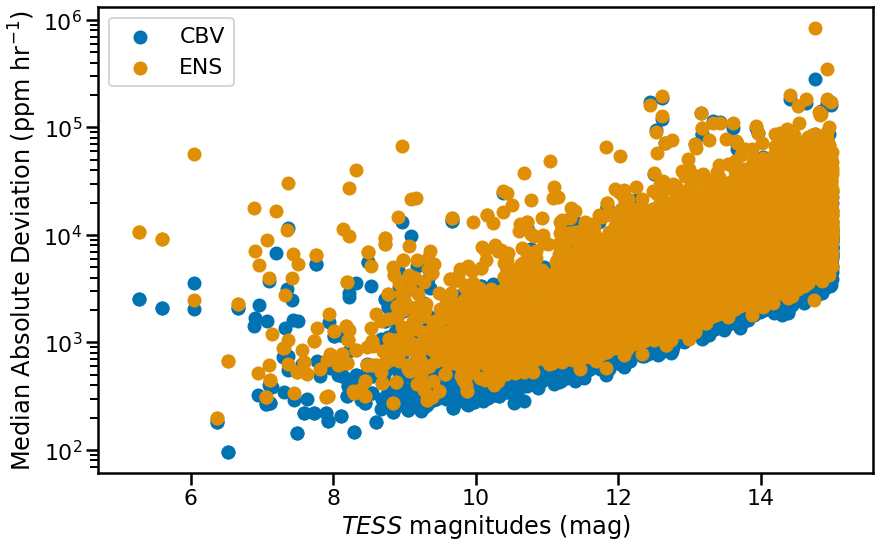

In [14]:
fig = plt.figure(figsize=mnras_size(1000))
ax = plt.gca()
ax.scatter(dia.tmag, dia.cbv_rms, label='CBV')
ax.scatter(dia.tmag, dia.ens_rms, label='ENS')
ax.set_xlabel(r'$TESS$ magnitudes (mag)')
ax.set_ylabel(r'Median Absolute Deviation (ppm hr$^{-1}$)')
ax.legend(loc='upper left')
ax.set_yscale('log')
plt.show()

FliPer

In [15]:
dia

,priority,starid,lightcurve,elaptime,mean_flux,variance,variability,rms_hour,ptp,pos_row,...,ens_Fp_46,cbv_Fp_46,ens_Fp_93,cbv_Fp_93,ens_Fp_140,cbv_Fp_140,ens_Fp_186,cbv_Fp_186,ens_Fp_233,cbv_Fp_233
0,586,25299762,ffi/00025/tess00025299762-s01-c1800-dr01-v04-t...,36.852086,912444.281250,0.000087,232.707815,0.010749,0.000068,147.305276,...,1.167086e+04,7.882073e+03,11492.159439,3504.791861,3341.678886,1065.791517,1447.546333,524.662494,944.356189,865.185700
1,586,25299762,ffi/00025/tess00025299762-s01-c1800-dr01-v04-t...,36.852086,912444.281250,0.000087,232.707815,0.010749,0.000068,147.305276,...,1.167086e+04,7.882073e+03,11492.159439,3504.791861,3341.678886,1065.791517,1447.546333,524.662494,944.356189,865.185700
2,878,25375770,ffi/00025/tess00025375770-s01-c1800-dr01-v04-t...,3.586985,695034.625000,0.000097,165.360705,0.009122,0.000090,739.214090,...,1.368268e+04,2.964265e+03,15391.753681,938.312514,5923.194127,351.973070,3397.993775,1060.622420,2801.797705,1265.678069
3,878,25375770,ffi/00025/tess00025375770-s01-c1800-dr01-v04-t...,3.586985,695034.625000,0.000097,165.360705,0.009122,0.000090,739.214090,...,1.368268e+04,2.964265e+03,15391.753681,938.312514,5923.194127,351.973070,3397.993775,1060.622420,2801.797705,1265.678069
4,1331,25132805,ffi/00025/tess00025132805-s01-c1800-dr01-v04-t...,4.584243,513845.484375,0.001793,139.145959,0.056619,0.000122,240.015037,...,1.843990e+05,-7.287398e+04,115728.970332,-83774.310194,94100.342547,-56122.847547,86463.867209,-14402.577307,85203.860257,27824.425537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,1380607,25079255,ffi/00025/tess00025079255-s01-c1800-dr01-v04-t...,10.855113,110.671383,0.000686,3.095125,0.011582,0.008074,367.021187,...,1.033813e+05,1.781048e+05,46185.516389,76603.217444,15106.533869,44076.934404,43411.652422,41871.532744,154927.555032,100070.337308
10101,1380877,25354068,ffi/00025/tess00025354068-s01-c1800-dr01-v04-t...,3.731334,76.042534,0.002683,4.165312,0.026272,0.011935,353.334389,...,1.251149e+06,1.701125e+05,382436.604829,89885.439492,293083.106220,72553.711133,391736.227360,119184.256065,416050.009399,158635.216823
10102,1380819,25166939,ffi/00025/tess00025166939-s01-c1800-dr01-v04-t...,15.513803,132.848297,36.401353,537.208208,0.035189,0.013174,675.914974,...,1.468971e+06,1.432151e+06,403713.043513,665326.549620,334245.595488,184594.755635,510150.515078,61488.820852,520848.548951,281333.014221
10103,1381347,25373391,ffi/00025/tess00025373391-s01-c1800-dr01-v04-t...,5.782632,109.037422,0.019585,12.392593,0.014702,0.010613,107.335287,...,5.351956e+05,4.065418e+05,258537.773034,132955.678411,113602.273751,20570.518597,198312.873712,78407.204735,191238.350364,171377.414101


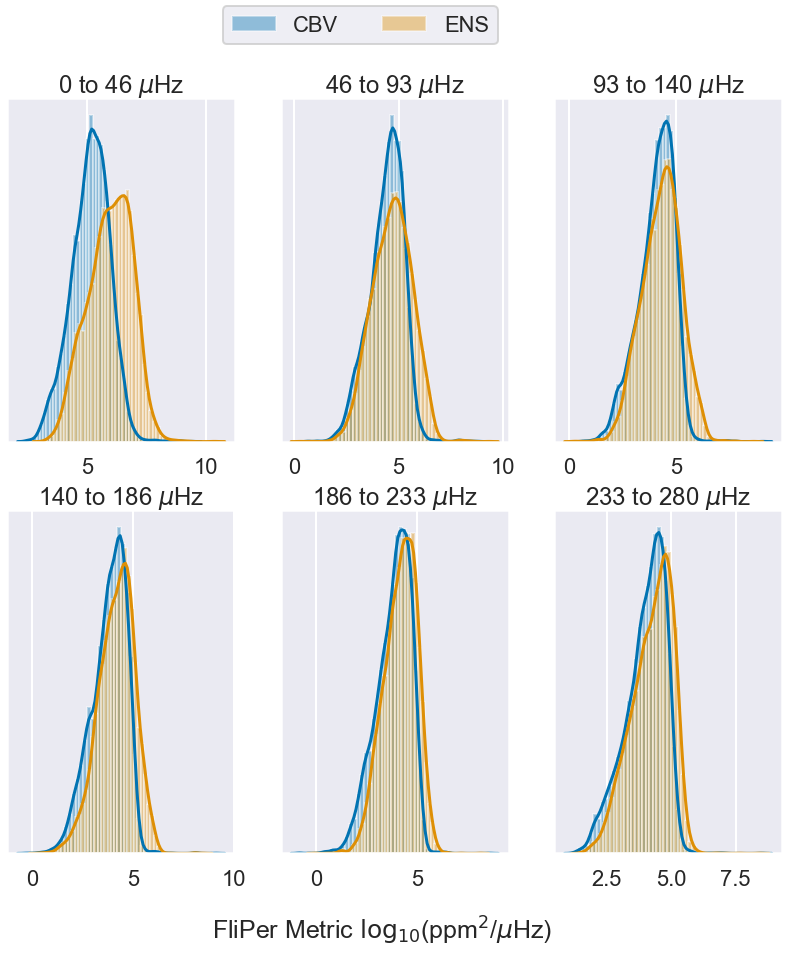

In [16]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(2,3, sharex=False, figsize=mnras_size(1000, square=True))
axes = axes.flatten()
for idx, row in enumerate(fpi[:-1]):
    ax = axes[idx]
    v = int(fpi[idx])
    ax.set_title(fr'{v} to {int(fpi[idx+1])} $\mu$Hz')
    a = np.log10(dia[f'cbv_Fp_{v}'].dropna())
    b = np.log10(dia[f'ens_Fp_{v}'].dropna())
    sns.distplot(a[np.isfinite(a)], label='CBV',ax=ax, axlabel=False)
    sns.distplot(b[np.isfinite(b)], label='ENS',ax=ax, axlabel=False)
    ax.get_yaxis().set_visible(False)
fig.text(0.5, 0.04, r'FliPer Metric $\log_{10}$(ppm$^2$/$\mu$Hz)', ha='center', fontsize=25)
axes[0].legend(bbox_to_anchor=(2.2, 1.3), ncol=2)

plt.show()